In [1]:
from random import randint, shuffle # random integers and random shuffling of a list
from itertools import permutations # iterate over all possible permutations of a list
from math import inf as oo # Infinity (∞) is larger than any number
from math import sqrt, log, factorial  # square root, logarithm, and n!
from time import perf_counter # for measuring time. NB. 'perf_counter' is better/more accurate than 'time'
import networkx as nx # to draw sample graphs
import pandas as pd # to show the adjacency matrix in a nice format
import matplotlib.pyplot as plt # to plot graphs of time and quality vs n
import seaborn as sns # nice statistical plots -- see e.g. https://seaborn.pydata.org/tutorial/relational.html#relational-tutorial
sns.set_style("white")

In [13]:
class Graph:
    """ Random graphs """
    def __init__(self, n=0, type="asymmetric", MAX_WEIGHT=100, MAX_X=200, MAX_Y=200):
        self.n = n
        self.vertices = list(range(n)) # [0,1,...,n-1]
        self.type = type
        self.adj_matrix = [[oo for i in range(n)] for j in range(n)]
        # Generate a random adjacency matrix according to the required type
        if type == "symmetric": self.__random_symmetric_graph(n, MAX_WEIGHT)
        elif type == "Euclidean": self.__random_euclidean_graph(n, MAX_X,MAX_Y)
        elif type == "easy": self.__random_cycle_graph(n)
        else: self.__random_asymmetric_graph(n, MAX_WEIGHT) # assume "asymmetric" otherwise
            
    def __getitem__(self, i):
        """ Allow indexing to get the weights """
        return self.adj_matrix[i]
                
    def __random_asymmetric_graph(self, n, MAX_WEIGHT):
        """ Asymmetric adjacency matrix of size nxn """
        for i in range(n):
            for j in range(n):
                if i == j: continue # no self-loops
                self.adj_matrix[i][j] = randint(1, MAX_WEIGHT)

    def __random_symmetric_graph(self, n, MAX_WEIGHT):
        """ Symmetric adjacency matrix of size nxn """
        for i in range(n):
            for j in range(i + 1, n):
                w = randint(1, MAX_WEIGHT)
                self.adj_matrix[i][j] = w
                self.adj_matrix[j][i] = w

    def __random_cycle_graph(self,n):
        """ Symmetric adjacency matrix of size nxn with one reandomly chosen cycle
        All the edge weights are 2 except for the cycle (weight=1) """
        self.adj_matrix = [[2 for _ in range(n)] for _ in range(n)] # All weights=2
        # Select a random cycle which will have weight=1
        cycle = list(range(1, n)) # don't include 0 as we want to be at the start
        shuffle(cycle) # in-place random permutation
        cycle = [0]+cycle+[0] # cycle starting and ending at 0
        for a, b in zip(cycle, cycle[1:]): # set the cycle's weights to 1
            self.adj_matrix[a][b] = 1
            self.adj_matrix[b][a] = 1

    def __random_euclidean_graph(self, n, MAX_X, MAX_Y):
        """ Symmetric adjacency matrix of a Euclidean graph of size nxn """
        # (1/2) Generate random (x,y) points
        points = set()
        while len(points) < n: # We may get duplicate (x,y) so we try until we get enough points
            x, y = randint(0, MAX_X), randint(0, MAX_Y)
            points.add((x, y))
        points = list(points) # Sets are not indexed, so convert into a list
        # (2/2) Now compute the adjacency matrix
        for i in range(n):
            p1 = points[i]
            for j in range(i+1, n):
                p2 = points[j]
                distance = sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
                self.adj_matrix[i][j] = distance
                self.adj_matrix[j][i] = distance
        self.points = points

In [3]:
def cost(G, cycle):
    """ Calculate the cost of the given cycle [0,...,0] in G """
    return sum(G[a][b] for a, b in zip(cycle, cycle[1:]))

In [10]:
def show(G):
    """ Show adjacency matrix. Useful for debugging.
    'type' is a string from: Euclidean, Cycle, ...
    The distances are round to 1 decimal point for clarity/simplicity
    """
    print(f"{G.n}x{G.n} {G.type} graph:")
    if G.type == "Euclidean": print("Points:", G.points)
    r = pd.DataFrame({str(i): G[i] for i in range(G.n)})
    display(r)  # ipynb specific
    
def nx_graph(G):
    """ Convert G into NetworkX format """
    nxG = nx.Graph() if G.type != "asymmetric" else nx.DiGraph() # undirected/directed graph
    nxG.add_nodes_from(G.vertices) # Add the vertices
    # Now add the edges
    for a in G.vertices:
        for b in G.vertices:
            if a == b: continue # no self-loops
            nxG.add_edge(a, b, weight=G[a][b])        
    if G.type == "Euclidean": # add (x,y) coordinates if available
        pos = dict(enumerate(G.points)) # vertex:(x,y) pairs
        nx.set_node_attributes(nxG, pos, "coord")
    return nxG

def draw(G):
    """ Draw the graph G using NetworkX """
    nxG = nx_graph(G)
    weights_dictionary = nx.get_edge_attributes(nxG, "weight")
    edges, weights = zip(*weights_dictionary.items())
    pos = nx.circular_layout(nxG) if G.type != "Euclidean" else nx.get_node_attributes(nxG, "coord")
    nx.draw(nxG, pos, \
            with_labels=True, node_color="red", font_color="white", font_weight="bold", font_size=14,\
            edge_color=weights, width=1.5, connectionstyle="arc3, rad=0.1", edge_cmap=plt.cm.copper)
    # see https://matplotlib.org/stable/gallery/color/colormap_reference.html
    nx.draw_networkx_edge_labels(nxG, pos, edge_labels=weights_dictionary)

8x8 euclidean graph:


,0,1,2,3,4,5,6,7
0,inf,64.0,58.0,56.0,18.0,33.0,55.0,38.0
1,19.0,inf,33.0,90.0,6.0,44.0,27.0,35.0
2,80.0,65.0,inf,75.0,38.0,46.0,88.0,56.0
3,52.0,18.0,3.0,inf,28.0,66.0,43.0,59.0
4,55.0,70.0,69.0,82.0,inf,47.0,47.0,81.0
5,63.0,21.0,84.0,63.0,41.0,inf,52.0,53.0
6,21.0,92.0,25.0,17.0,56.0,45.0,inf,8.0
7,2.0,63.0,24.0,42.0,90.0,13.0,100.0,inf


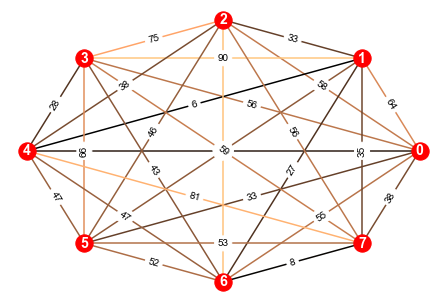

In [14]:
G = Graph(8,"euclidean")
show(G)
draw(G)